# 1 探索数据


数据集使用 kaggle 数据集，解压后存放在images目录下
- 训练数据集路径：
images/train
- 测试数据集路径：
images/test

# 1.1 整理数据集
 
这里由于 trian 文件夹下的猫和狗的数据是混在一起的，需要将猫和狗的图片分别存储。

图片的命名规则：类别.编码.jpg

**注意：这里的处理只需要运行一次即可**


In [67]:
import os
import shutil
from glob import glob

def create_dir(path):
    '''
    创建文件夹
    '''
    if (os.path.exists(path) == False):
        os.mkdir (path)
    else:
        print('文件夹已经存在：%s' % path)

# 限制训练文件数量,0不限制
def copy_image_bytype(srcfiles, path, limitcount = 0):
    '''
    将猫狗文件分别拷贝到不同文件夹下
    '''
   
    filenames = [item.split("\\")[-1] for item in sorted(srcfiles)]
    count = len(filenames)

    
    for src,name in zip(srcfiles,filenames):
        dst = path + "/" + name
        if (os.path.exists(dst) == False):
            shutil.copyfile(src, dst)

        # 跳出循环
        limitcount = limitcount - 1
        if (limitcount == 0):
            break
            
    return count

In [68]:
# 创建文件夹
all_path = 'images/all'
train_path = 'images/all/trainnew'
dog_path = 'images/all/trainnew/dogs'
cat_path = 'images/all/trainnew/cats'

testnew_path = 'images/all/testnew'
test_path = 'images/all/testnew/test'

create_dir(all_path)

create_dir(train_path)
create_dir(dog_path)
create_dir(cat_path)

create_dir(testnew_path)
create_dir(test_path)


文件夹已经存在：images/all
文件夹已经存在：images/all/trainnew
文件夹已经存在：images/all/trainnew/dogs
文件夹已经存在：images/all/trainnew/cats
文件夹已经存在：images/all/testnew
文件夹已经存在：images/all/testnew/test


In [70]:
# 处理狗
dogs_list = glob("images/train/dog.*")

# 整理狗数据
# copy_image_bytype(dogs_list, dog_path, 10000)
count = copy_image_bytype(dogs_list, dog_path)

print('There are %d total dog categories.' % count)


There are 12500 total dog categories.


In [71]:
# 处理猫
cats_list = glob("images/train/cat.*")

# 整理猫数据
# copy_image_bytype(cats_list, cat_path, 10000)
count = copy_image_bytype(cats_list, cat_path)

print('There are %d total cat categories.' % count)


There are 12500 total cat categories.


In [72]:
# 处理测试数据
test_list = glob("images/test/*")

# 打印数据统计描述
test_filenames = [item.split("/")[-1] for item in sorted(test_list)]
print('There are %d total test categories.' % len(test_filenames))

# 整理猫数据
# copy_image_bytype(test_list, test_path, 5000)
count = copy_image_bytype(test_list, test_path)

print('There are %d total test categories.' % count)


There are 12500 total test categories.
There are 12500 total test categories.


## 1.2 导入数据

In [73]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np


### 1.2.1 加载 train 数据集

In [74]:
# 加载 train 测试数据集
train_data = load_files(train_path)
trainall_file = np.array(train_data['filenames'])
trainall_targets = np_utils.to_categorical(np.array(train_data['target']), 2)
# print(type(train_data))
# print(train_targets)

# 展示训练数据集
print('训练集数据总数：%d' % len(trainall_file))


训练集数据总数：25000


### 1.2.2 加载 test 数据集

In [75]:
# 加载 test 测试数据集
test_data = load_files(testnew_path)
test_files = np.array(test_data['filenames'])
test_targets = np_utils.to_categorical(np.array(test_data['target']), 1)

# 展示测试数据集
print('测试集数据总数：%d' % len(test_files))

测试集数据总数：12500


## 1.3 数据可视化

In [131]:
import matplotlib.pyplot as plt
from scipy.stats import mode as spmode
from PIL import Image


def get_filesizes(paths):
    '''
    获取文件大小
    '''
    filesizes = []
    for path in paths:
        size = os.path.getsize(path)
        filesizes.append(size)
    return filesizes

def get_filepixs(paths):
    '''
    获取像素：长和宽
    '''
    filepixs = []
    xpixs = []
    ypixs = []
    for path in paths:
        img = Image.open(path)
        pix = img.size #图片的长和宽
        xpixs.append(pix[0]) #图片的宽
        ypixs.append(pix[1]) #图片的长
        if (pix[0] > 1000):
            print(path)
    filepixs.append(xpixs)
    filepixs.append(ypixs)    
    
    return filepixs
    

In [132]:
# filepixs = get_filepixs(trainall_file[:20])
# print(filepixs[0])
# print(filepixs[1])
# print(trainall_file[:20])

In [133]:
def draw_hist(mylist, title, xlabel, ylabel, xmin, xmax, ymin, ymax):
    '''
    绘制直方图，参数依次为list,抬头,X轴标签,Y轴标签,XY轴的范围
    '''
    plt.hist(mylist, 100)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
def draw_scatter(x1, y1, title, label):
    '''
    绘制像素的散点图
    '''
    plt.scatter(x1, y1, marker = 'x',color = 'red', s = 40 ,label = label)
    plt.xlabel('wide')
    plt.ylabel('length')
    plt.title(title)
    
#     plt.xlim(-1.5, 1.5)
#     plt.xticks(())  # ignore xticks
#     plt.ylim(-1.5, 1.5)
#     plt.yticks(())  # ignore yticks

    plt.show()    

In [135]:

def show_filesize(paths):
    '''
    展示文件大小分布
    '''
    filesizes = get_filesizes(paths)

    # train 中文件的的最小值、最大值、中位数、众数
    train_min = np.min(filesizes)
    print('train 中文件的的最小值:', train_min)
    train_max = np.max(filesizes)
    print('train 中文件的的最大值:', train_max)
    train_median = np.median(filesizes)
    print('train 中文件的的中位数:', train_median)
    train_mode = spmode(filesizes)
    print('train 中文件的的众数:', train_mode)
        
    title = 'file size distribute'
    xlabel = 'file size'
    ylabel = 'file count'
    xmin = np.min(filesizes)
    xmax = np.max(filesizes)
    ymin = 0
    ymax = 1200
    draw_hist(filesizes, title, xlabel, ylabel, xmin, xmax, ymin, ymax)

def show_filepix(paths):
    '''
    显示像素分布
    '''
    filepixs = get_filepixs(paths)
    title = 'file pix distribute'
    draw_scatter(filepixs[0], filepixs[1], title, 'dog')

images/train\dog.2317.jpg


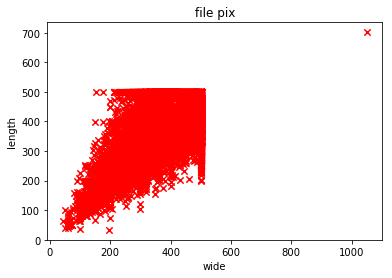

In [136]:
show_filepix(dogs_list)

images/train\cat.835.jpg


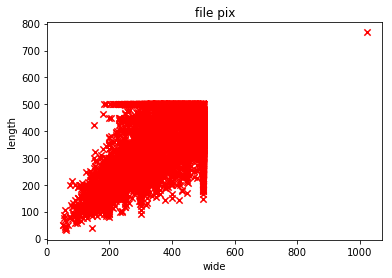

In [137]:
show_filepix(cats_list)

train 中文件的的最小值: 1106
train 中文件的的最大值: 93323
train 中文件的的中位数: 22165.5
train 中文件的的众数: ModeResult(mode=array([20918]), count=array([6]))


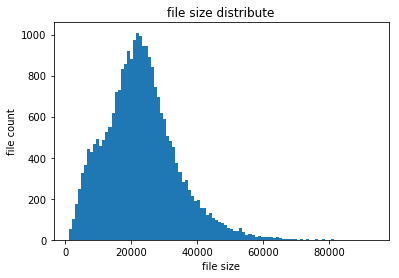

In [138]:
# 训练数据集文件大小的分布
show_filesize(trainall_file)        


train 中文件的的最小值: 1131
train 中文件的的最大值: 86322
train 中文件的的中位数: 22061.0
train 中文件的的众数: ModeResult(mode=array([19960]), count=array([6]))


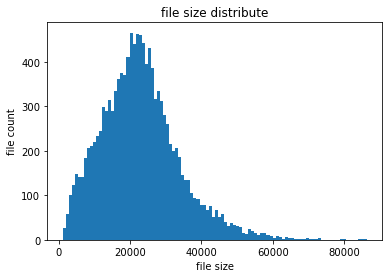

In [139]:
# 测试数据集文件大小的分布
show_filesize(test_files)        


## 1.4 数据预处理

### 1.4.1 分割训练集

In [140]:
from sklearn.model_selection import train_test_split

# 将原来的训练数据分割成训练数据集和验证数据集，比例为20%
train_files, valid_files, train_targets, valid_targets = train_test_split(trainall_file, trainall_targets, test_size=0.2)

print(len(train_files))
print(len(valid_files))
# print(tarin_targets)
# print(valid_targets)

20000
5000


### 1.4.2 异常数据清理

异常数据有:

标签与图片信息不相符的，例如：虽然标识了是狗的图片，但是图片中没有狗。

照片的背景过于复杂，识别起来很困难，例如：虽然有狗但是有很多干扰元素。

这里选择4种算法:ResNet50, VGG19, Xception, InceptionV3 获取的并集进行数据清理



In [151]:
from keras.preprocessing import image
import numpy as np

# 对 ImageNet 分类进行分析
# 狗分类：118种，猫分类：7种

ImageNetdogs = [
 'n02085620','n02085782','n02085936','n02086079'
,'n02086240','n02086646','n02086910','n02087046'
,'n02087394','n02088094','n02088238','n02088364'
,'n02088466','n02088632','n02089078','n02089867'
,'n02089973','n02090379','n02090622','n02090721'
,'n02091032','n02091134','n02091244','n02091467'
,'n02091635','n02091831','n02092002','n02092339'
,'n02093256','n02093428','n02093647','n02093754'
,'n02093859','n02093991','n02094114','n02094258'
,'n02094433','n02095314','n02095570','n02095889'
,'n02096051','n02096177','n02096294','n02096437'
,'n02096585','n02097047','n02097130','n02097209'
,'n02097298','n02097474','n02097658','n02098105'
,'n02098286','n02098413','n02099267','n02099429'
,'n02099601','n02099712','n02099849','n02100236'
,'n02100583','n02100735','n02100877','n02101006'
,'n02101388','n02101556','n02102040','n02102177'
,'n02102318','n02102480','n02102973','n02104029'
,'n02104365','n02105056','n02105162','n02105251'
,'n02105412','n02105505','n02105641','n02105855'
,'n02106030','n02106166','n02106382','n02106550'
,'n02106662','n02107142','n02107312','n02107574'
,'n02107683','n02107908','n02108000','n02108089'
,'n02108422','n02108551','n02108915','n02109047'
,'n02109525','n02109961','n02110063','n02110185'
,'n02110341','n02110627','n02110806','n02110958'
,'n02111129','n02111277','n02111500','n02111889'
,'n02112018','n02112137','n02112350','n02112706'
,'n02113023','n02113186','n02113624','n02113712'
,'n02113799','n02113978']

ImageNetcats=[
'n02123045','n02123159','n02123394','n02123597'
,'n02124075','n02125311','n02127052']

In [183]:
def get_not_animalarray(model, top, animalarray,img_paths, xsize, ysize):
    '''
    清理数据集中不是对应标签的文件
    model:模型
    animalarray: ImageNet分类集
    img_paths:数据集路径
    x:图片宽
    y:图片高
    '''
    animals = []
    for img_path in img_paths:
#         print(img_path)
#         print(x)
#         print(y)
        img = image.load_img(img_path, target_size=(xsize, ysize))
        imgarray = image.img_to_array(img)
        imgarray = np.expand_dims(imgarray, axis=0)
        imgarray = preprocess_input(imgarray)

        preds = model.predict(imgarray)
#         tmparray = decode_predictions(preds, top=top)
#         sorted(tmparray, key=lambda tmp: tmp[2], reverse=True) 
#         print(tmparray)
        animal = decode_predictions(preds, top=top)[0][0][0]

        if animal not in animalarray:
            animals.append(img_path)
#             print('id:',decode_predictions(preds, top=5)[0][0][0])
#             print('type:',decode_predictions(preds, top=5)[0][0][1])
#             print('rate:',decode_predictions(preds, top=5)[0][0][2])
            
    return animals

# Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]

#### 利用ResNet50网络进行ImageNet分类

In [206]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions


topparma = 50
doglimit = 10
catlimit = 10

ResNet50_model = ResNet50(weights='imagenet')

# 不是狗的
ResNet50_notdogs = get_not_animalarray(ResNet50_model, topparma, ImageNetdogs, dogs_list[0:doglimit], 224, 224)
print(ResNet50_notdogs)

# 不是猫的
ResNet50_notcats = get_not_animalarray(ResNet50_model, topparma, ImageNetcats, cats_list[0:catlimit], 224, 224)
print(ResNet50_notdogs)   

[]
[]


#### 利用VGG19网络进行ImageNet分类

In [207]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input,decode_predictions


VGG19_model = VGG19(weights='imagenet')

# 不是狗的
VGG19_notdogs = get_not_animalarray(VGG19_model, topparma, ImageNetdogs, dogs_list[0:doglimit], 224, 224)
print(VGG19_notdogs)

# 不是猫的
VGG19_notcats = get_not_animalarray(VGG19_model, topparma, ImageNetcats, cats_list[0:catlimit], 224, 224)
print(VGG19_notcats)   

['images/train\\dog.10001.jpg']
['images/train\\cat.0.jpg', 'images/train\\cat.100.jpg', 'images/train\\cat.1000.jpg', 'images/train\\cat.10001.jpg']


#### 利用Xception网络进行ImageNet分类

In [208]:
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input,decode_predictions


Xception_model = Xception(weights='imagenet')

# 不是狗的
Xception_notdogs = get_not_animalarray(Xception_model, topparma, ImageNetdogs, dogs_list[0:doglimit], 299, 299)
print(Xception_notdogs)

# 不是猫的
Xception_notcats = get_not_animalarray(Xception_model, topparma, ImageNetcats, cats_list[0:catlimit], 299, 299)
print(Xception_notcats) 

[]
[]


#### 利用InceptionV3网络进行ImageNet分类

In [209]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input,decode_predictions

InceptionV3_model = InceptionV3(weights='imagenet')

# 不是狗的
InceptionV3_notdogs = get_not_animalarray(InceptionV3_model, topparma, ImageNetdogs, dogs_list[0:doglimit], 299, 299)
print(InceptionV3_notdogs)

# 不是猫的
InceptionV3_notcats = get_not_animalarray(InceptionV3_model, topparma, ImageNetcats, cats_list[0:catlimit], 299, 299)
print(InceptionV3_notcats) 

[]
['images/train\\cat.10001.jpg']


In [210]:
# 合并所有的结果，取并集
notdogs = ResNet50_notdogs + VGG19_notdogs + Xception_notdogs + InceptionV3_notdogs
notdogs = list(set(notdogs))
print(notdogs)

notcats = ResNet50_notcats + VGG19_notcats + Xception_notcats + InceptionV3_notdogs
notcats = list(set(notcats))
print(notcats)


['images/train\\dog.10001.jpg']
['images/train\\cat.0.jpg', 'images/train\\cat.10001.jpg', 'images/train\\cat.100.jpg', 'images/train\\cat.10003.jpg', 'images/train\\cat.1000.jpg']


In [ ]:
import cv2
import numpy as np

def show_multiple_image(images):
    
    count = 0
    for image1 in images:
        img1 = cv2.imread(image1)

        # resize to same scale
        im1 = cv2.resize(img1, (200, 200))
        
        count += 1
        if (count % 2 == 0):
            hmerge = np.hstack((im1,)) #水平拼接
            cv2.imshow("test1", hmerge)
        else:
            vmerge = np.vstack((im1,)) #垂直拼接
            cv2.imshow("test2", vmerge)

    cv2.waitKey(0)
    cv2.destroyAllWindows()



In [ ]:
print(notdogs)
show_multiple_image(notdogs)

### 1.4.3 图像预处理

通过对每张图像的像素值除以299，我们对图像实现了归一化处理

In [12]:
from keras.preprocessing import image
from tqdm import tqdm
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

def path_to_tensor(img_path):
#     print(img_path)
    # 用PIL加载RGB图像为PIL.Image.Image类型
    img = image.load_img(img_path,target_size=(299,299))
    
    #将PIL.Image.Image类型转化为格式为(299,299,3)的3维张量
    x = image.img_to_array(img)
    
    #将3维张量转化为格式为(1, 299, 299, 3) 的4维张量并返回
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

# img_path='images/all/train/trainnew/cats/cat.4424.jpg'
# path_to_tensor(img_path)




In [13]:
starttime = time.strftime('start time:%Y.%m.%d',time.localtime(time.time()))
print (starttime)

# 训练集预处理
train_tensors = paths_to_tensor(train_files).astype('float32')/127.5 - 1


endtime = time.strftime('end time:%Y.%m.%d',time.localtime(time.time()))
print (endtime)

100%|██████████| 20000/20000 [01:05<00:00, 304.28it/s]


In [14]:
starttime = time.strftime('start time:%Y.%m.%d',time.localtime(time.time()))
print (starttime)

# 验证集预处理
valid_tensors = paths_to_tensor(valid_files).astype('float32')/127.5 - 1


endtime = time.strftime('end time:%Y.%m.%d',time.localtime(time.time()))
print (endtime)

100%|██████████| 5000/5000 [00:14<00:00, 342.19it/s]


In [15]:
starttime = time.strftime('start time:%Y.%m.%d',time.localtime(time.time()))
print (starttime)

# 测试集预处理
test_tensors = paths_to_tensor(test_files).astype('float32')/127.5 - 1


endtime = time.strftime('end time:%Y.%m.%d',time.localtime(time.time()))
print (endtime)

100%|██████████| 12500/12500 [00:38<00:00, 325.91it/s]


# 2 构建模型



## 2.1 训练模型

训练 InceptionV3 模型

In [16]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
 


In [17]:
# 1.构建不带分类器的预训练模型
base_model = InceptionV3(weights='imagenet',include_top=False) 

In [18]:
# 2.添加全局平均池化层
x = base_model.output
x = GlobalAveragePooling2D()(x)


In [19]:
# 3.全连接层，可选，如果精度够用则可以不加
# x = Dense(1024, activation='relu')(x)


In [20]:
# 4. 添加一个分类器，使用 1 个神经元，sigmoid激活函数
predictions = Dense(2, activation='sigmoid')(x)


In [21]:
# 5. 构建我们需要训练的完整模型
model = Model(inputs=base_model.input, outputs=predictions)


In [22]:
# 6.首先只训练顶部的几层（随机初始化的层），锁住所有 InceptionV3d 卷积层
for layer in base_model.layers:
    layer.trainable = False


In [23]:
starttime = time.strftime('start time:%Y.%m.%d',time.localtime(time.time()))
print (starttime)

# 7.编译模型（一定要在锁层以后操作）
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')


endtime = time.strftime('end time:%Y.%m.%d',time.localtime(time.time()))
print (endtime)

In [25]:
starttime = time.strftime('start time:%Y.%m.%d',time.localtime(time.time()))
print (starttime)

# 8. 在新的数据集上训练几代
# early stoppping 
from keras.callbacks import EarlyStopping

# monitor: 需要监视的变量
# patience:在发现变量没有变化后的多少个epoch停止
# verbose:信息展示模式
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
#          epochs=300, batch_size=1, verbose=1, callbacks=[early_stopping])
model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
         epochs=300, batch_size=64, verbose=1, callbacks=[early_stopping])


endtime = time.strftime('end time:%Y.%m.%d',time.localtime(time.time()))
print (endtime)

Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 2341s - loss: 0.2965 - val_loss: 0.1716
Epoch 2/3
20000/20000 [==============================] - 2341s - loss: 0.2959 - val_loss: 0.1201
Epoch 3/3
20000/20000 [==============================] - 2342s - loss: 0.2850 - val_loss: 0.1726


In [40]:
# 9.现在顶层应该训练好了，开始微调 InceptionV3的卷积层。
#锁住底下的几层，然后训练其余的顶层。查看每一层的名字和层号，看看应该锁多少层
# for i, layer in enumerate(base_model.layers):
#     print(i, layer.name)
 

In [41]:
# 10.我们选择训练最上面的两个 Inception block, 锁住前面249层，然后放开之后的层
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True


In [42]:
from keras.optimizers import SGD

# 11.重新编译模型，使上面的修改生效，设置一个很低的学习率，使用SGD来微调
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])
print('compile ok')

compile ok


In [43]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

starttime = time.strftime('start time:%Y.%m.%d',time.localtime(time.time()))
print (starttime)

# 12.继续训练模型，训练最后两个 Inception block 和两个全连接层
Inceptionfile_hdf5 ='saved_models/weights.best.Inception.hdf5'

# 模型保存
checkpointer = ModelCheckpoint(filepath=Inceptionfile_hdf5, verbose=1, save_best_only=True)

# 可视化
tensorboard = TensorBoard(log_dir='log')

# 自动停止训练
# monitor: 需要监视的变量
# patience:在发现变量没有变化后的多少个epoch停止
# verbose:信息展示模式
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


callback_lists = [tensorboard, checkpointer, early_stopping]

# # 训练模型
# history_callback = model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
#          epochs=300, batch_size=1,callbacks=callback_lists,shuffle='True',verbose=1)

history_callback = model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
         epochs=300, batch_size=64,callbacks=callback_lists,shuffle='True',verbose=1)


endtime = time.strftime('end time:%Y.%m.%d',time.localtime(time.time()))
print (endtime)

Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 3050s - loss: 0.0125 - acc: 0.9957 - val_loss: 0.0382 - val_acc: 0.9888
Epoch 2/3
20000/20000 [==============================] - 3049s - loss: 0.0094 - acc: 0.9963 - val_loss: 0.0404 - val_acc: 0.9882
Epoch 3/3
20000/20000 [==============================] - 3052s - loss: 0.0104 - acc: 0.9960 - val_loss: 0.0436 - val_acc: 0.9888


## 2.2 可视化

### 2.2.1 logloss 趋势图

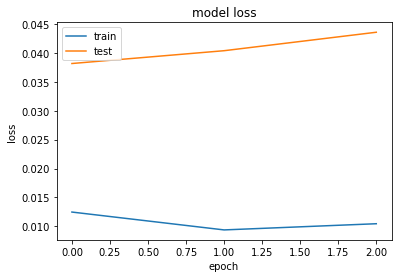

In [76]:
# logloss 趋势图
plt.plot(history_callback.history['loss'])
plt.plot(history_callback.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train","test"],loc="upper left")

plt.show()

### 2.2.1 准确率趋势图

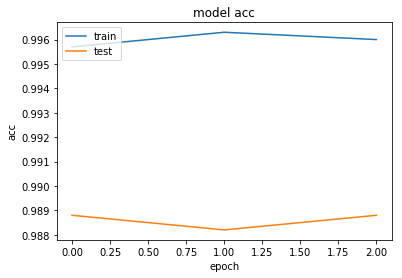

In [77]:
# logloss 趋势图
plt.plot(history_callback.history['acc'])
plt.plot(history_callback.history['val_acc'])
plt.title("model acc")
plt.ylabel("acc")
plt.xlabel("epoch")
plt.legend(["train","test"],loc="upper left")

plt.show()

## 2.2 测试模型

在测试数据集上试用训练后的模型

In [48]:
## 加载具有最好验证loss的模型
starttime = time.strftime('start time:%Y.%m.%d',time.localtime(time.time()))
print (starttime)

model.load_weights(Inceptionfile_hdf5)

# 获取测试数据集中每一个图像所预测的狗品种的index
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# 报告测试准确率
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

loss_history = history_callback.history['loss']
print(loss_history)

endtime = time.strftime('end time:%Y.%m.%d',time.localtime(time.time()))
print (endtime)



Test accuracy: 49.8960%
[0.012463728536172284, 0.00937279501457715, 0.01044361965330004]
